Importing stuff

In [1]:
import torch
import torchaudio
from datasets import load_metric, Dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ProcessorWithLM
import kenlm
from pyctcdecode import build_ctcdecoder
from IPython.display import Audio
from pathlib import Path
import json

vad_model, vad_utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = vad_utils

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /home/peterr/.cache/torch/hub/master.zip


In [2]:
wav = read_audio(f'audio/s1iBR07bVrg_clipped.wav', sampling_rate=16000)
vad_ts=get_speech_timestamps(wav, vad_model, sampling_rate=16000, speech_pad_ms=1000, return_seconds=True)
print(f'Found {len(vad_ts)} segments')

Found 216 segments


In [3]:
from numpy import ceil


def resample(ts, max_gap=3, max_len=30):
    for s in ts:
        if s["end"] - s["start"] > max_len:
            print(
                f"Error: max_len ({max_len}) is smaller than one of the segments ({s})!"
            )
            return None
    gts = []
    g = [ts[0]]
    for s in ts[1:]:
        if s["start"] - g[-1]["end"] < max_gap:
            g.append(s)
        else:
            gts.append(g)
            g = [s]
    gts.append(g)
    ret = []
    for g in gts:
        l = g[-1]["end"] - g[0]["start"]
        split_num = ceil(l / max_len)
        if split_num > 1:
            min_len = l / split_num
            start = g[0]["start"]
            end = g[0]["end"]
            for s in g[1:]:
                if s["end"] - start > max_len or end - start > min_len:
                    ret.append({"start": start, "end": end})
                    start = s["start"]
                    end = s["end"]
                else:
                    end = s["end"]
            ret.append({"start": start, "end": end})
        else:
            ret.append({"start": g[0]["start"], "end": g[-1]["end"]})
    return ret
ts=resample(vad_ts)
print(f'Found {len(ts)} segments')
print(ts)

Found 42 segments
[{'start': 0.2, 'end': 18.3}, {'start': 18.3, 'end': 43.2}, {'start': 43.2, 'end': 71.6}, {'start': 71.6, 'end': 98.5}, {'start': 98.5, 'end': 122.4}, {'start': 122.4, 'end': 140.9}, {'start': 140.9, 'end': 170.1}, {'start': 170.1, 'end': 198.8}, {'start': 198.8, 'end': 226.7}, {'start': 226.7, 'end': 253.2}, {'start': 253.9, 'end': 278.9}, {'start': 278.9, 'end': 307.2}, {'start': 307.2, 'end': 330.4}, {'start': 330.4, 'end': 356.2}, {'start': 356.2, 'end': 384.7}, {'start': 384.7, 'end': 414.5}, {'start': 414.5, 'end': 439.1}, {'start': 439.1, 'end': 467.0}, {'start': 467.0, 'end': 494.5}, {'start': 494.5, 'end': 520.9}, {'start': 522.4, 'end': 547.8}, {'start': 547.8, 'end': 576.1}, {'start': 576.1, 'end': 600.8}, {'start': 600.8, 'end': 630.6}, {'start': 630.6, 'end': 659.8}, {'start': 659.8, 'end': 688.2}, {'start': 688.2, 'end': 713.6}, {'start': 713.6, 'end': 742.4}, {'start': 742.4, 'end': 767.4}, {'start': 767.4, 'end': 794.4}, {'start': 794.4, 'end': 823.6},

In [4]:
from numpy import linspace, zeros, logical_and

wav_data = wav.numpy()
T = wav_data.size / 16000.0
t = linspace(0, T, wav_data.size)


sil = zeros(10 * (int(T) + 1))  # 10 pts per second
sil_x = linspace(0, T, sil.size)

for n, tx in enumerate(ts):
    m = logical_and(sil_x >= tx["start"], sil_x <= tx["end"])
    sil[m] = (n & 1) + 1


(0.0, 90.0)

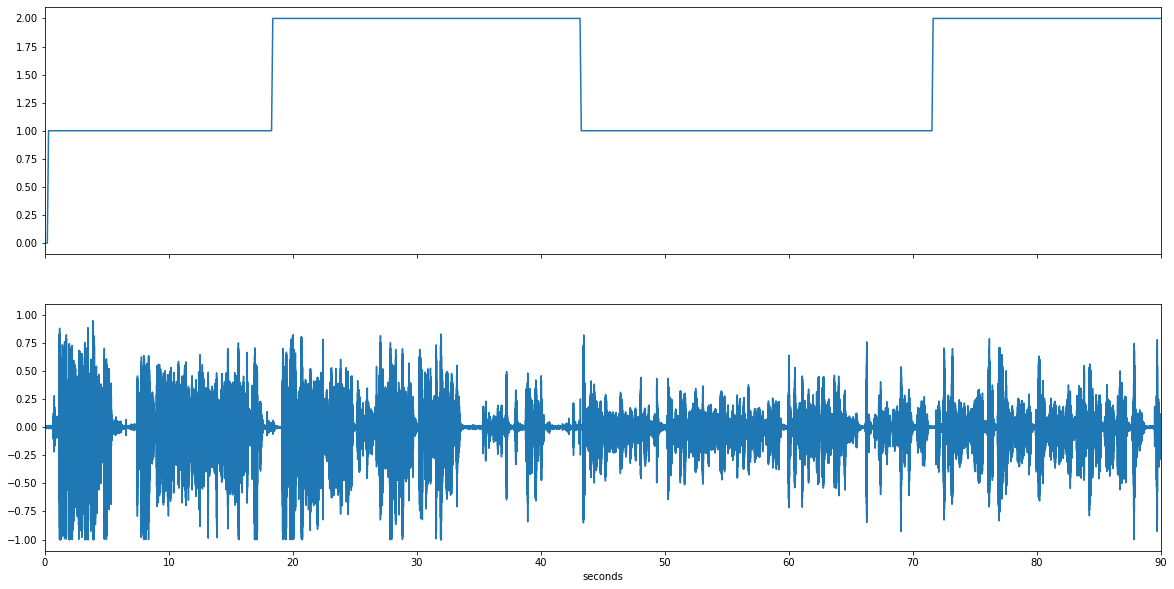

In [5]:
from matplotlib.pyplot import subplots, xlabel, xlim
fig,ax=subplots(2,1,sharex=True,figsize=(20,10))
ax[0].plot(sil_x,sil)
ax[1].plot(t,wav_data)
xlabel('seconds')
xlim(0,90)

In [6]:
model_name = "classla/wav2vec2-xls-r-parlaspeech-hr"
device = "cuda"

model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
processor = Wav2Vec2Processor.from_pretrained(model_name)

sampling_rate = 16000

files = {"sample": Path("audio/s1iBR07bVrg_clipped.wav")}

ds_dict = {"file": [], "start": [], "end": []}
for seg in ts:
    ds_dict["file"].append("sample")
    ds_dict["start"].append(seg["start"])
    ds_dict["end"].append(seg["end"])
ds = Dataset.from_dict(ds_dict)

wavcache = {}


def map_to_array(batch):
    if batch["file"] in wavcache:
        speech = wavcache[batch["file"]]
    else:
        path = files[batch["file"]]
        speech, _ = torchaudio.load(path)
        speech = speech.squeeze(0).numpy()
        wavcache[batch["file"]] = speech
    sstart = int(batch["start"] * sampling_rate)
    send = int(batch["end"] * sampling_rate)
    batch["speech"] = speech[sstart:send]
    return batch


ds = ds.map(map_to_array)


def map_to_pred(batch):
    features = processor(
        batch["speech"], sampling_rate=sampling_rate, padding=True, return_tensors="pt"
    )
    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits
    pred_ids = torch.argmax(logits, dim=-1)
    batch["predicted"] = processor.batch_decode(pred_ids)
    return batch


result = ds.map(map_to_pred, batched=True, batch_size=8)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [7]:
result['predicted']

['konačni prijedlog zakona o izmjenama i dopunama zakona o pravu na pristup informacijama to je prijedlog zakona br 199to nije u drugom čitanju sa svim karakteristikama koje imaju zakon u drugom čitanju značaj amandmani se mogu podninuti do kraja rasprave',
 'raspravu su provedio odbor za zakonodavstvo i odbor za ustav poslovnik politički sustav odbor za informiranje informacije i medija znači t odbora žuli li predstavnik predlagatelja održavni tajnik gospodin juro martinević iz ministarstva pravosuđa i uprave uzeti riječss stanka stanka gje vi izvolite gospođo oreškovi stanka',
 'hvala predsjedavatelju tražim stanku u ime kluba stranke centar i stranke i glasa trajanju od 10 minuta radi dodatnih konzultacija naime prije svega želim ukazati na činjenicu da je u ovom trenu praktički prazna sabornica da je prisutno svega 10tak saborskih zastupnika i to uoči početka rasprave o jednom od najvažnijih antikorupcijskih zakonaae',
 'dakle radi se o zakonu koji je ishodište početak svakog prava

In [8]:
result.column_names

['file', 'start', 'end', 'speech', 'predicted']

In [9]:
result["start"]

[0.2,
 18.3,
 43.2,
 71.6,
 98.5,
 122.4,
 140.9,
 170.1,
 198.8,
 226.7,
 253.9,
 278.9,
 307.2,
 330.4,
 356.2,
 384.7,
 414.5,
 439.1,
 467.0,
 494.5,
 522.4,
 547.8,
 576.1,
 600.8,
 630.6,
 659.8,
 688.2,
 713.6,
 742.4,
 767.4,
 794.4,
 823.9,
 836.3,
 860.7,
 877.7,
 907.1,
 936.8,
 963.9,
 990.7,
 1011.9,
 1040.4,
 1069.9]

Constructing a wrapper for a single file:

In [10]:
from myutils import process_file

process_file("audio_2.wav")

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

,file,start,end,predicted
0,audio_2.wav,6.7,26.5,upoznato meseju o luskoi izvan jednoj deceni ...
1,audio_2.wav,26.5,45.9,da bi citira teško bilo u si 19. veka prenaći ...
2,audio_2.wav,45.9,63.7,sve ideje koje nalazimo ne samo što su izrasle...
3,audio_2.wav,63.7,79.9,ova ocjena se ne odnosi samo na onu struju rus...
4,audio_2.wav,79.9,95.2,koji su u svom učenju ljudskoj kulturnoj sanob...
...,...,...,...,...
97,audio_2.wav,1713.4,1730.8,da srbija nije samo radikalska da nije samo kr...
98,audio_2.wav,1730.8,1746.0,ona je nešto što povremeno trpi poraze ali se ...
99,audio_2.wav,1746.0,1764.1,da je odrovno misliti bez obzira na vrijeme u ...
100,audio_2.wav,1764.1,1782.5,mnogo veće danas nego što su bile na prjelazu ...


Doing it on whole Južne Vesti corpus:

In [11]:
import pandas as pd
from tqdm.auto import tqdm
from myutils import process_file
corpus = pd.read_csv("006_crawling_juznevesti.csv")
dfs = []
for i, path in tqdm(enumerate(corpus.path)):
    try:
        dfs.append(process_file(path))
    except Exception as e:
        print(f"Error at file nr {i}.")
df = pd.concat(dfs, ignore_index=True)

df.to_csv("011_segments.csv", index=False)

0it [00:00, ?it/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 43.5, 'end': 65.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 97.2, 'end': 123.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 126.9, 'end': 160.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 168.4, 'end': 253.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 260.4, 'end': 289.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 369.6, 'end': 398.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 398.5, 'end': 465.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 465.0, 'end': 510.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 538.0, 'end': 561.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 600.2, 'end': 627.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 632.8, 'end': 657.6})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 266.5, 'end': 295.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 151.2, 'end': 181.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 299.0, 'end': 319.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 321.8, 'end': 398.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 398.4, 'end': 456.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 461.2, 'end': 483.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 483.4, 'end': 504.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 511.4, 'end': 551.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 638.4, 'end': 678.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 712.4, 'end': 741.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 741.5, 'end': 761.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 763.5, 'end': 790.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 131.1, 'end': 158.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 530.1, 'end': 558.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 579.7, 'end': 612.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 513.7, 'end': 534.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 1533.0, 'end': 1554.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 46.5, 'end': 68.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 235.1, 'end': 261.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 261.7, 'end': 285.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 405.3, 'end': 430.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 430.6, 'end': 459.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 590.4, 'end': 617.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 617.2, 'end': 646.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 684.0, 'end': 714.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 715.8, 'end': 741.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 47.2, 'end': 69.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 400.3, 'end': 425.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 729.3, 'end': 760.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 1053.1, 'end': 1074.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 61.4, 'end': 81.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 97.7, 'end': 145.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 161.5, 'end': 201.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 207.9, 'end': 249.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 249.8, 'end': 279.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 295.3, 'end': 355.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 358.0, 'end': 387.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 387.3, 'end': 437.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 437.1, 'end': 510.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 546.3, 'end': 581.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 591.1, 'end': 630.9})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 73.2, 'end': 96.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 98.9, 'end': 125.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 252.4, 'end': 289.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 466.6, 'end': 495.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 536.2, 'end': 557.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 567.9, 'end': 601.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 741.1, 'end': 763.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 828.7, 'end': 860.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 903.3, 'end': 924.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 138.8, 'end': 165.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 192.8, 'end': 228.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 228.8, 'end': 253.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 345.2, 'end': 370.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 407.5, 'end': 449.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 517.4, 'end': 558.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 632.0, 'end': 654.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 753.6, 'end': 778.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 823.5, 'end': 850.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 865.4, 'end': 891.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 900.8, 'end': 938.3})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 19.4, 'end': 46.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 96.1, 'end': 127.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 257.8, 'end': 278.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 429.3, 'end': 455.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 467.1, 'end': 490.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 510.1, 'end': 539.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 600.7, 'end': 623.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 153.4, 'end': 173.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 11.8, 'end': 31.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 187.9, 'end': 242.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 282.5, 'end': 342.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 342.1, 'end': 368.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 439.9, 'end': 464.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 534.3, 'end': 563.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 612.8, 'end': 662.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 662.2, 'end': 694.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 731.9, 'end': 752.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 752.0, 'end': 773.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 799.2, 'end': 845.3})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 39.6, 'end': 60.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 129.6, 'end': 163.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 235.3, 'end': 265.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 407.5, 'end': 431.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 630.4, 'end': 666.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 865.2, 'end': 887.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 899.1, 'end': 931.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 1029.8, 'end': 1049.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 198.0, 'end': 226.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 479.0, 'end': 502.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 778.2, 'end': 809.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 903.4, 'end': 926.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 56.4, 'end': 83.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 101.9, 'end': 138.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 153.6, 'end': 215.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 256.4, 'end': 293.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 304.2, 'end': 326.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 338.4, 'end': 363.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 380.5, 'end': 446.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 466.6, 'end': 490.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 527.0, 'end': 563.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 588.0, 'end': 618.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 644.2, 'end': 669.6})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 48.0, 'end': 75.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 75.9, 'end': 100.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 108.9, 'end': 139.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 152.7, 'end': 203.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 203.1, 'end': 336.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 343.6, 'end': 405.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 409.3, 'end': 437.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 437.7, 'end': 495.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 529.2, 'end': 614.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 634.2, 'end': 681.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 720.7, 'end': 743.3})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 92.5, 'end': 114.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 114.8, 'end': 147.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 385.7, 'end': 417.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 500.4, 'end': 520.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 528.3, 'end': 551.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 625.4, 'end': 660.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 931.0, 'end': 971.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 1050.4, 'end': 1076.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 91.0, 'end': 116.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 119.8, 'end': 158.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 161.4, 'end': 183.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 220.5, 'end': 242.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 324.8, 'end': 353.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 452.2, 'end': 481.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 521.2, 'end': 544.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 559.0, 'end': 595.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 620.4, 'end': 651.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 693.8, 'end': 729.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 741.1, 'end': 763.9})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 46.4, 'end': 67.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 92.3, 'end': 129.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 141.5, 'end': 264.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 269.5, 'end': 430.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 454.8, 'end': 497.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 497.4, 'end': 522.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 522.1, 'end': 543.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 543.7, 'end': 591.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 614.2, 'end': 649.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 679.8, 'end': 759.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 759.0, 'end': 802.4})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Error at file nr 23.


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 176.4, 'end': 197.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 196.3, 'end': 217.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 287.8, 'end': 313.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 118.4, 'end': 140.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 929.3, 'end': 951.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 715.9, 'end': 738.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 768.6, 'end': 793.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 21.3, 'end': 45.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 53.7, 'end': 73.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 73.9, 'end': 107.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 107.7, 'end': 145.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 163.3, 'end': 188.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 198.0, 'end': 273.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 273.5, 'end': 299.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 328.0, 'end': 362.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 362.0, 'end': 415.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 415.3, 'end': 435.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 470.6, 'end': 520.2})!
Error: max_len 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 212.9, 'end': 233.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 906.1, 'end': 927.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 765.2, 'end': 787.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 331.8, 'end': 354.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 392.5, 'end': 418.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 478.7, 'end': 507.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 714.1, 'end': 753.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 16.2, 'end': 44.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 44.2, 'end': 67.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 385.0, 'end': 406.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 543.2, 'end': 565.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 649.7, 'end': 675.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 1159.4, 'end': 1179.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 1179.9, 'end': 1202.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 76.0, 'end': 127.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 127.2, 'end': 198.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 229.2, 'end': 263.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 267.1, 'end': 288.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 291.2, 'end': 345.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 360.2, 'end': 508.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 508.2, 'end': 566.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 566.5, 'end': 681.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 703.7, 'end': 755.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 768.2, 'end': 938.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 958.1, 'end': 1102.8})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Error at file nr 36.


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 456.8, 'end': 480.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 677.5, 'end': 700.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 700.8, 'end': 739.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 326.5, 'end': 352.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 550.3, 'end': 572.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 595.0, 'end': 626.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 265.7, 'end': 286.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 401.6, 'end': 433.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 433.9, 'end': 457.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 496.2, 'end': 522.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 592.0, 'end': 624.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 737.6, 'end': 761.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 779.6, 'end': 808.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 821.4, 'end': 852.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 313.1, 'end': 355.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 830.5, 'end': 856.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 205.1, 'end': 229.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 558.8, 'end': 579.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 783.2, 'end': 804.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 360.8, 'end': 394.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 513.9, 'end': 540.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 833.3, 'end': 865.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 206.9, 'end': 227.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 343.1, 'end': 363.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 908.9, 'end': 931.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 161.7, 'end': 182.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 218.4, 'end': 278.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 284.1, 'end': 308.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 308.3, 'end': 338.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 353.5, 'end': 373.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 453.2, 'end': 473.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 485.2, 'end': 516.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 519.1, 'end': 549.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 650.9, 'end': 684.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 753.8, 'end': 774.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 849.3, 'end': 869.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 103.8, 'end': 124.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 845.9, 'end': 877.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 81.7, 'end': 129.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 181.7, 'end': 219.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 219.8, 'end': 247.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 247.9, 'end': 268.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 321.6, 'end': 379.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 379.3, 'end': 431.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 449.5, 'end': 470.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 470.6, 'end': 499.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 504.5, 'end': 533.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 589.9, 'end': 639.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 684.3, 'end': 734.4})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 516.5, 'end': 538.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 753.1, 'end': 775.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 24.0, 'end': 75.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 114.5, 'end': 136.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 148.7, 'end': 169.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 253.9, 'end': 283.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 514.7, 'end': 553.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 570.5, 'end': 636.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 636.8, 'end': 659.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 660.1, 'end': 686.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 773.0, 'end': 807.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 807.4, 'end': 840.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 858.8, 'end': 883.5})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 83.8, 'end': 112.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 184.9, 'end': 206.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 262.8, 'end': 285.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 290.6, 'end': 325.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 325.2, 'end': 350.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 470.7, 'end': 510.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 617.1, 'end': 647.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 764.4, 'end': 791.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 804.2, 'end': 825.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 124.3, 'end': 152.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 152.4, 'end': 179.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 342.0, 'end': 362.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 432.3, 'end': 462.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 476.4, 'end': 509.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 566.7, 'end': 605.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 654.1, 'end': 678.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 808.4, 'end': 841.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 919.2, 'end': 942.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 281.8, 'end': 304.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 690.0, 'end': 716.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 866.3, 'end': 886.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 59.5, 'end': 81.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 93.1, 'end': 116.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 158.5, 'end': 226.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 230.0, 'end': 254.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 303.1, 'end': 336.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 382.5, 'end': 403.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 412.0, 'end': 457.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 504.6, 'end': 558.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 574.8, 'end': 601.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 650.6, 'end': 682.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 712.8, 'end': 735.1})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 386.8, 'end': 411.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 487.7, 'end': 510.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 624.3, 'end': 663.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 667.8, 'end': 728.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 734.6, 'end': 757.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 757.3, 'end': 781.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 799.7, 'end': 820.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 820.7, 'end': 853.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 853.7, 'end': 895.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 895.7, 'end': 942.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 966.1, 'end': 991.5})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 494.3, 'end': 520.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 61.8, 'end': 107.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 107.5, 'end': 128.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 136.0, 'end': 162.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 162.3, 'end': 188.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 212.7, 'end': 269.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 323.2, 'end': 359.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 420.9, 'end': 457.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 457.1, 'end': 496.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 527.1, 'end': 605.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 682.7, 'end': 708.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 729.7, 'end': 784.2})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 153.7, 'end': 183.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 231.1, 'end': 275.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 373.3, 'end': 405.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 405.3, 'end': 430.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 446.8, 'end': 467.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 546.5, 'end': 567.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 637.7, 'end': 661.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 400.1, 'end': 426.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 544.6, 'end': 589.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 594.4, 'end': 633.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 697.2, 'end': 754.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 874.9, 'end': 897.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 965.0, 'end': 988.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 217.0, 'end': 239.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 239.9, 'end': 269.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 269.2, 'end': 292.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 335.6, 'end': 355.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 442.4, 'end': 477.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 629.2, 'end': 663.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 663.6, 'end': 704.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 775.2, 'end': 799.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 829.0, 'end': 852.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 852.1, 'end': 872.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 877.8, 'end': 901.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 523.9, 'end': 551.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 228.1, 'end': 248.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 306.8, 'end': 333.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 504.4, 'end': 535.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 274.8, 'end': 299.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 933.3, 'end': 954.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 100.3, 'end': 159.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 202.3, 'end': 226.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 242.7, 'end': 266.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 273.8, 'end': 303.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 367.3, 'end': 436.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 436.9, 'end': 462.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 487.2, 'end': 514.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 552.6, 'end': 583.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 595.3, 'end': 625.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 629.4, 'end': 652.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 692.4, 'end': 719.0})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 111.7, 'end': 165.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 276.5, 'end': 298.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 301.6, 'end': 323.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 363.9, 'end': 388.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 509.4, 'end': 542.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 619.1, 'end': 654.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 839.3, 'end': 867.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 1158.9, 'end': 1179.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 187.9, 'end': 215.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 221.1, 'end': 242.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 254.5, 'end': 297.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 417.4, 'end': 443.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 497.0, 'end': 517.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 615.7, 'end': 642.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 687.5, 'end': 711.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 869.5, 'end': 895.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 83.6, 'end': 156.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 190.0, 'end': 215.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 255.6, 'end': 276.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 313.3, 'end': 337.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 387.9, 'end': 418.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 474.9, 'end': 500.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 528.6, 'end': 549.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 612.8, 'end': 643.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 652.3, 'end': 697.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 728.8, 'end': 755.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 789.6, 'end': 810.3})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 117.1, 'end': 137.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 321.8, 'end': 348.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 368.8, 'end': 392.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 412.9, 'end': 456.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 645.3, 'end': 666.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 706.1, 'end': 739.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 849.6, 'end': 879.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 889.1, 'end': 918.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 455.4, 'end': 477.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 548.9, 'end': 571.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 192.3, 'end': 214.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 238.9, 'end': 292.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 445.0, 'end': 469.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 490.0, 'end': 519.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 519.7, 'end': 551.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 563.8, 'end': 591.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 591.3, 'end': 616.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 645.2, 'end': 667.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 704.6, 'end': 741.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 805.6, 'end': 829.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 870.3, 'end': 896.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 51.1, 'end': 74.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 80.6, 'end': 106.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 106.5, 'end': 129.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 129.4, 'end': 171.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 171.4, 'end': 209.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 256.8, 'end': 323.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 324.4, 'end': 354.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 388.7, 'end': 410.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 442.8, 'end': 481.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 596.5, 'end': 645.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 778.4, 'end': 800.1})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 178.2, 'end': 219.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 317.6, 'end': 344.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 353.2, 'end': 384.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 438.6, 'end': 465.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 465.3, 'end': 490.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 563.5, 'end': 591.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 613.7, 'end': 664.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 664.0, 'end': 692.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 719.0, 'end': 739.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 739.5, 'end': 761.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 724.9, 'end': 747.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 1395.7, 'end': 1416.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 96.7, 'end': 118.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 184.1, 'end': 209.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 209.2, 'end': 241.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 255.1, 'end': 285.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 478.5, 'end': 515.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 528.5, 'end': 555.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 555.2, 'end': 576.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 708.8, 'end': 730.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 730.6, 'end': 756.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 813.6, 'end': 838.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 704.6, 'end': 736.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 769.9, 'end': 794.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 326.7, 'end': 350.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 504.8, 'end': 531.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 50.0, 'end': 71.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 82.6, 'end': 112.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 112.5, 'end': 162.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 162.3, 'end': 183.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 185.2, 'end': 215.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 222.4, 'end': 250.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 286.2, 'end': 310.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 337.0, 'end': 375.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 430.1, 'end': 517.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 517.7, 'end': 547.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 547.2, 'end': 569.5})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 185.4, 'end': 214.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 214.0, 'end': 234.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 237.4, 'end': 257.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 257.7, 'end': 288.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 381.9, 'end': 414.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 414.6, 'end': 451.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 466.5, 'end': 505.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 641.1, 'end': 671.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 689.1, 'end': 726.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 726.7, 'end': 749.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 749.7, 'end': 779.1})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 95.0, 'end': 115.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 128.6, 'end': 172.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 173.4, 'end': 206.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 206.7, 'end': 227.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 254.3, 'end': 292.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 322.3, 'end': 371.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 371.2, 'end': 404.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 404.9, 'end': 425.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 509.4, 'end': 532.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 565.7, 'end': 597.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 648.8, 'end': 672.0})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 125.1, 'end': 167.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 301.6, 'end': 341.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 345.1, 'end': 383.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 394.3, 'end': 446.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 464.2, 'end': 568.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 604.3, 'end': 669.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 676.1, 'end': 706.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 706.5, 'end': 729.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 729.9, 'end': 766.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 803.0, 'end': 852.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 158.9, 'end': 179.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 608.7, 'end': 633.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 727.2, 'end': 749.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 120.1, 'end': 140.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 201.7, 'end': 234.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 284.9, 'end': 314.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 353.9, 'end': 384.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 401.1, 'end': 443.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 533.1, 'end': 554.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 687.6, 'end': 717.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 759.8, 'end': 779.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 839.8, 'end': 864.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 459.2, 'end': 482.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 293.4, 'end': 314.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 355.1, 'end': 395.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 419.5, 'end': 440.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 541.5, 'end': 565.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 582.5, 'end': 605.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 625.1, 'end': 660.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 740.4, 'end': 775.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 832.5, 'end': 853.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 1091.6, 'end': 1113.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 55.2, 'end': 90.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 90.0, 'end': 184.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 184.9, 'end': 213.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 254.5, 'end': 323.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 417.7, 'end': 447.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 494.6, 'end': 538.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 591.2, 'end': 613.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 674.6, 'end': 697.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 724.3, 'end': 748.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 158.2, 'end': 180.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 208.2, 'end': 241.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 263.2, 'end': 297.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 352.1, 'end': 373.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 373.8, 'end': 394.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 419.0, 'end': 445.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 516.0, 'end': 537.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 574.0, 'end': 595.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 598.1, 'end': 619.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 680.2, 'end': 740.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 784.1, 'end': 817.2})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 309.2, 'end': 334.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 71.4, 'end': 97.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 97.7, 'end': 122.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 144.8, 'end': 165.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 254.5, 'end': 280.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 318.9, 'end': 351.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 606.0, 'end': 651.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 656.2, 'end': 677.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 878.3, 'end': 899.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 917.0, 'end': 959.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 973.7, 'end': 1021.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 256.2, 'end': 277.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 375.0, 'end': 404.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 452.8, 'end': 478.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 742.8, 'end': 766.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 814.9, 'end': 835.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 574.9, 'end': 598.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 632.1, 'end': 655.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 411.8, 'end': 433.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 623.1, 'end': 645.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 1059.1, 'end': 1080.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 44.0, 'end': 66.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 109.2, 'end': 129.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 141.7, 'end': 170.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 184.9, 'end': 214.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 214.1, 'end': 235.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 598.9, 'end': 622.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 669.2, 'end': 692.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 808.2, 'end': 831.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 61.6, 'end': 379.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 392.4, 'end': 499.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 505.8, 'end': 548.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 558.4, 'end': 645.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 645.3, 'end': 695.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 695.4, 'end': 717.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 717.5, 'end': 741.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 741.9, 'end': 764.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 764.4, 'end': 786.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 821.9, 'end': 846.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 865.3, 'end': 896.5})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Error at file nr 117.


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 30.0, 'end': 90.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 90.5, 'end': 193.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 197.8, 'end': 239.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 239.8, 'end': 273.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 273.0, 'end': 492.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 492.0, 'end': 641.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 641.1, 'end': 716.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 716.8, 'end': 741.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 741.8, 'end': 813.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 813.6, 'end': 875.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 875.7, 'end': 1069.8})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Error at file nr 118.


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 492.5, 'end': 513.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 215.9, 'end': 236.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 129.6, 'end': 154.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 84.6, 'end': 110.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 132.9, 'end': 158.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 178.8, 'end': 216.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 246.4, 'end': 270.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 291.1, 'end': 317.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 402.7, 'end': 426.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 653.6, 'end': 713.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 826.1, 'end': 856.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 876.7, 'end': 903.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 47.9, 'end': 132.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 132.5, 'end': 157.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 157.9, 'end': 195.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 196.5, 'end': 231.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 245.3, 'end': 282.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 282.7, 'end': 368.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 368.6, 'end': 395.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 395.6, 'end': 474.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 477.5, 'end': 511.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 511.6, 'end': 571.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 625.9, 'end': 654.5})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 135.4, 'end': 160.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 507.7, 'end': 536.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 536.4, 'end': 581.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 600.0, 'end': 647.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 701.6, 'end': 731.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 846.0, 'end': 887.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 887.6, 'end': 912.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 974.7, 'end': 997.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 1080.7, 'end': 1101.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 245.7, 'end': 276.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 286.4, 'end': 309.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 310.5, 'end': 334.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 46.0, 'end': 153.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 166.4, 'end': 201.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 201.0, 'end': 246.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 246.2, 'end': 322.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 322.8, 'end': 367.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 371.9, 'end': 500.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 500.3, 'end': 552.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 552.2, 'end': 575.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 591.8, 'end': 675.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 688.5, 'end': 725.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 725.8, 'end': 747.6})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 27.7, 'end': 51.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 87.2, 'end': 113.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 136.1, 'end': 156.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 156.4, 'end': 180.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 198.0, 'end': 219.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 453.6, 'end': 475.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 646.8, 'end': 673.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 677.0, 'end': 699.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 718.8, 'end': 740.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 742.9, 'end': 767.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 770.7, 'end': 793.3})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 130.8, 'end': 154.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 83.0, 'end': 113.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 137.2, 'end': 166.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 166.9, 'end': 202.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 225.5, 'end': 250.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 378.4, 'end': 408.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 421.1, 'end': 460.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 476.8, 'end': 498.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 540.2, 'end': 572.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 572.6, 'end': 597.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 597.8, 'end': 621.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 656.0, 'end': 688.7})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 11.3, 'end': 33.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 37.2, 'end': 96.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 115.0, 'end': 181.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 181.5, 'end': 243.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 258.2, 'end': 287.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 313.3, 'end': 345.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 345.6, 'end': 369.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 388.7, 'end': 415.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 415.2, 'end': 452.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 458.7, 'end': 482.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 482.0, 'end': 503.3})!
Error: max_len

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 59.3, 'end': 87.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 101.2, 'end': 126.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 212.5, 'end': 233.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 353.1, 'end': 375.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 393.8, 'end': 423.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 164.4, 'end': 192.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 202.7, 'end': 224.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 393.5, 'end': 425.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 480.3, 'end': 504.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 568.3, 'end': 591.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 683.3, 'end': 710.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 842.6, 'end': 868.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 956.4, 'end': 990.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 1094.2, 'end': 1134.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 73.0, 'end': 93.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 93.3, 'end': 117.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 147.9, 'end': 172.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 172.2, 'end': 220.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 220.8, 'end': 254.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 260.8, 'end': 284.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 295.5, 'end': 327.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 332.0, 'end': 367.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 394.6, 'end': 429.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 481.0, 'end': 511.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 744.7, 'end': 777.4})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 25.2, 'end': 47.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 502.1, 'end': 526.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 851.9, 'end': 876.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 945.8, 'end': 969.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 70.5, 'end': 96.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 174.0, 'end': 198.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 207.1, 'end': 227.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 253.8, 'end': 276.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 276.7, 'end': 307.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 336.1, 'end': 357.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 368.1, 'end': 399.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 412.4, 'end': 433.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 474.0, 'end': 498.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 498.8, 'end': 519.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 580.0, 'end': 608.6})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 191.7, 'end': 211.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 477.3, 'end': 502.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 513.6, 'end': 547.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 567.7, 'end': 595.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 614.4, 'end': 634.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 831.4, 'end': 854.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 102.6, 'end': 132.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 132.7, 'end': 155.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 164.0, 'end': 257.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 270.2, 'end': 309.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 309.4, 'end': 359.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 359.6, 'end': 394.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 394.5, 'end': 424.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 444.3, 'end': 499.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 499.8, 'end': 558.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 560.7, 'end': 610.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 610.6, 'end': 653.7})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 33.8, 'end': 67.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 104.0, 'end': 164.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 182.4, 'end': 208.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 254.3, 'end': 294.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 308.3, 'end': 341.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 341.2, 'end': 391.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 391.0, 'end': 435.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 435.5, 'end': 463.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 472.0, 'end': 497.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 523.6, 'end': 555.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 555.6, 'end': 588.9})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 503.8, 'end': 528.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 802.2, 'end': 822.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 207.2, 'end': 228.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 240.2, 'end': 268.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 334.3, 'end': 354.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 354.8, 'end': 381.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 554.8, 'end': 575.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 972.5, 'end': 1012.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 50.8, 'end': 91.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 161.3, 'end': 251.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 256.4, 'end': 357.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 373.4, 'end': 443.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 456.4, 'end': 566.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 577.4, 'end': 616.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 627.8, 'end': 661.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 662.1, 'end': 683.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 723.2, 'end': 760.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 776.1, 'end': 819.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 825.6, 'end': 875.9})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 600.9, 'end': 623.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 758.7, 'end': 785.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 1059.3, 'end': 1084.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 121.4, 'end': 144.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 177.7, 'end': 204.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 220.2, 'end': 270.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 270.8, 'end': 298.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 341.6, 'end': 362.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 382.7, 'end': 404.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 431.7, 'end': 462.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 500.2, 'end': 525.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 553.5, 'end': 586.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 596.3, 'end': 625.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 625.4, 'end': 667.4})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 54.3, 'end': 83.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 158.6, 'end': 211.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 236.0, 'end': 256.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 268.7, 'end': 302.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 313.0, 'end': 336.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 351.0, 'end': 372.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 379.7, 'end': 425.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 467.8, 'end': 488.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 530.6, 'end': 591.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 591.5, 'end': 658.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 690.6, 'end': 712.1})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 164.2, 'end': 190.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 269.4, 'end': 297.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 325.5, 'end': 348.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 364.7, 'end': 385.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 444.0, 'end': 473.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 488.5, 'end': 511.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 514.1, 'end': 535.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 642.6, 'end': 665.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 762.7, 'end': 799.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 801.4, 'end': 821.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 959.8, 'end': 984.1})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 55.3, 'end': 76.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 119.4, 'end': 143.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 143.5, 'end': 164.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 180.0, 'end': 202.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 263.5, 'end': 298.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 397.1, 'end': 420.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 420.4, 'end': 446.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 505.2, 'end': 528.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 581.2, 'end': 612.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 638.8, 'end': 663.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 832.8, 'end': 852.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 63.9, 'end': 88.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 200.3, 'end': 227.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 227.3, 'end': 251.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 281.4, 'end': 372.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 462.7, 'end': 518.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 524.9, 'end': 548.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 548.7, 'end': 584.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 584.7, 'end': 620.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 652.0, 'end': 728.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 741.6, 'end': 769.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 769.3, 'end': 825.5})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 66.0, 'end': 121.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 121.9, 'end': 149.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 166.3, 'end': 215.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 215.3, 'end': 236.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 236.3, 'end': 275.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 275.4, 'end': 300.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 307.7, 'end': 329.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 329.2, 'end': 356.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 368.9, 'end': 501.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 501.3, 'end': 559.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 559.4, 'end': 582.0})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 478.4, 'end': 509.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 662.8, 'end': 687.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 198.5, 'end': 219.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 246.1, 'end': 270.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 413.5, 'end': 446.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 465.0, 'end': 489.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 624.7, 'end': 646.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 852.8, 'end': 876.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 46.3, 'end': 66.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 238.8, 'end': 259.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 271.1, 'end': 294.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 412.1, 'end': 455.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 508.8, 'end': 536.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 608.8, 'end': 632.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 906.8, 'end': 928.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 332.4, 'end': 358.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 467.3, 'end': 496.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 660.9, 'end': 681.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 811.5, 'end': 835.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 269.3, 'end': 301.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 391.7, 'end': 413.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 78.5, 'end': 101.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 101.1, 'end': 153.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 178.8, 'end': 206.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 209.4, 'end': 237.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 244.6, 'end': 272.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 303.5, 'end': 336.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 414.8, 'end': 437.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 437.8, 'end': 476.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 483.6, 'end': 507.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 508.8, 'end': 558.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 564.1, 'end': 587.9})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 87.9, 'end': 133.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 133.9, 'end': 158.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 233.6, 'end': 293.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 312.6, 'end': 349.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 360.7, 'end': 453.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 453.4, 'end': 485.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 525.1, 'end': 547.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 547.2, 'end': 575.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 649.8, 'end': 670.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 708.0, 'end': 741.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 760.9, 'end': 808.4})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 74.2, 'end': 110.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 110.2, 'end': 152.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 152.9, 'end': 178.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 204.5, 'end': 230.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 244.5, 'end': 279.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 291.4, 'end': 313.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 315.9, 'end': 369.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 385.5, 'end': 409.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 409.7, 'end': 433.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 438.4, 'end': 463.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 463.8, 'end': 513.2})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 422.4, 'end': 442.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 857.2, 'end': 879.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 31.1, 'end': 51.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 70.4, 'end': 90.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 191.7, 'end': 219.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 281.3, 'end': 307.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 355.2, 'end': 410.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 515.9, 'end': 540.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 545.8, 'end': 572.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 572.5, 'end': 602.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 602.5, 'end': 627.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 672.7, 'end': 702.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 743.2, 'end': 779.3})!
Error: max_len

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 158.2, 'end': 178.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 251.4, 'end': 281.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 377.8, 'end': 403.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 419.8, 'end': 440.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 447.4, 'end': 470.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 688.9, 'end': 715.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 27.3, 'end': 53.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 122.0, 'end': 161.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 248.0, 'end': 268.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 398.4, 'end': 420.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 576.4, 'end': 602.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 184.1, 'end': 208.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 234.9, 'end': 255.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 269.5, 'end': 293.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 445.1, 'end': 473.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 557.8, 'end': 582.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 745.8, 'end': 781.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 972.5, 'end': 1014.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 1047.4, 'end': 1076.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 167.0, 'end': 192.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 332.3, 'end': 354.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 403.3, 'end': 430.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 430.5, 'end': 460.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 478.3, 'end': 504.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 567.8, 'end': 594.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 635.1, 'end': 662.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 792.0, 'end': 812.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 823.8, 'end': 861.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 25.8, 'end': 52.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 146.5, 'end': 167.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 402.7, 'end': 440.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 464.0, 'end': 509.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 577.2, 'end': 603.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 611.6, 'end': 637.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 762.4, 'end': 798.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 850.6, 'end': 877.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 70.9, 'end': 97.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 171.9, 'end': 205.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 205.7, 'end': 236.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 248.4, 'end': 286.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 286.8, 'end': 311.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 322.8, 'end': 371.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 459.0, 'end': 515.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 517.9, 'end': 555.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 555.3, 'end': 587.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 638.4, 'end': 698.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 698.2, 'end': 780.2})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 101.2, 'end': 125.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 188.2, 'end': 212.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 349.8, 'end': 370.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 499.8, 'end': 520.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 735.0, 'end': 767.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 367.6, 'end': 391.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 466.0, 'end': 487.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 572.6, 'end': 593.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 594.6, 'end': 618.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 97.8, 'end': 118.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 136.6, 'end': 171.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 188.3, 'end': 222.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 301.0, 'end': 358.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 395.6, 'end': 493.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 505.2, 'end': 542.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 569.6, 'end': 633.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 633.6, 'end': 655.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 771.6, 'end': 801.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 824.4, 'end': 857.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 857.5, 'end': 877.8})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 16.1, 'end': 37.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 37.3, 'end': 58.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 220.6, 'end': 251.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 462.5, 'end': 484.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 507.7, 'end': 576.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 623.0, 'end': 649.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 728.8, 'end': 756.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 800.9, 'end': 833.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 926.1, 'end': 949.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 949.0, 'end': 987.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 987.7, 'end': 1009.3})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 293.7, 'end': 316.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 505.0, 'end': 529.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 831.2, 'end': 864.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 929.2, 'end': 958.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 88.8, 'end': 165.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 165.5, 'end': 189.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 217.5, 'end': 290.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 290.0, 'end': 313.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 313.9, 'end': 388.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 399.8, 'end': 485.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 592.7, 'end': 625.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 680.4, 'end': 722.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 722.8, 'end': 745.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 770.8, 'end': 834.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 840.9, 'end': 876.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 34.6, 'end': 63.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 68.0, 'end': 92.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 92.7, 'end': 151.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 151.6, 'end': 188.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 188.4, 'end': 212.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 212.7, 'end': 289.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 289.3, 'end': 321.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 331.3, 'end': 379.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 394.8, 'end': 438.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 438.2, 'end': 464.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 485.3, 'end': 506.3})!
Error: max_len 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 154.0, 'end': 180.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 212.6, 'end': 234.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 470.6, 'end': 491.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 734.4, 'end': 759.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 833.6, 'end': 863.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 902.6, 'end': 925.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 100.8, 'end': 126.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 147.8, 'end': 202.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 207.0, 'end': 239.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 271.0, 'end': 295.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 295.9, 'end': 339.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 339.1, 'end': 361.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 374.9, 'end': 398.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 415.0, 'end': 486.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 511.0, 'end': 538.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 538.8, 'end': 563.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 604.3, 'end': 632.9})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 170.8, 'end': 194.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 449.0, 'end': 470.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 920.8, 'end': 945.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 103.8, 'end': 127.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 140.3, 'end': 164.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 259.4, 'end': 280.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 311.8, 'end': 335.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 353.3, 'end': 382.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 382.3, 'end': 419.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 446.6, 'end': 480.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 586.7, 'end': 608.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 877.9, 'end': 899.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 134.6, 'end': 171.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 316.0, 'end': 336.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 336.4, 'end': 362.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 520.0, 'end': 546.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 583.7, 'end': 609.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 609.6, 'end': 637.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 640.2, 'end': 676.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 705.6, 'end': 727.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 794.0, 'end': 832.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 974.7, 'end': 1006.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 1011.6, 'end': 1039.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 118.7, 'end': 143.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 220.7, 'end': 242.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 242.9, 'end': 268.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 332.7, 'end': 380.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 437.4, 'end': 462.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 473.4, 'end': 508.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 547.6, 'end': 581.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 603.1, 'end': 626.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 647.9, 'end': 668.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 674.3, 'end': 703.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 747.4, 'end': 768.5})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 147.6, 'end': 195.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 594.9, 'end': 646.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 732.1, 'end': 757.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 819.4, 'end': 840.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 840.1, 'end': 875.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 887.0, 'end': 913.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 124.1, 'end': 150.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 514.6, 'end': 546.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 546.0, 'end': 574.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 656.3, 'end': 684.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 948.6, 'end': 978.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 990.2, 'end': 1012.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 620.7, 'end': 644.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 651.4, 'end': 677.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 702.3, 'end': 741.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 1083.6, 'end': 1107.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 1154.8, 'end': 1179.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 40.7, 'end': 79.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 110.4, 'end': 152.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 152.5, 'end': 195.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 236.5, 'end': 279.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 297.0, 'end': 346.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 376.6, 'end': 409.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 450.0, 'end': 472.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 586.7, 'end': 616.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 619.9, 'end': 687.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 687.3, 'end': 716.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 743.0, 'end': 772.6})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 56.7, 'end': 85.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 85.7, 'end': 127.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 127.3, 'end': 189.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 189.2, 'end': 220.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 220.3, 'end': 307.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 307.4, 'end': 328.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 331.5, 'end': 531.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 531.2, 'end': 594.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 594.6, 'end': 624.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 633.2, 'end': 654.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 654.0, 'end': 676.8})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Error at file nr 199.


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 192.6, 'end': 218.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 252.2, 'end': 272.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 416.1, 'end': 452.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 783.9, 'end': 810.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 206.0, 'end': 227.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 377.2, 'end': 399.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 449.4, 'end': 471.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 498.4, 'end': 523.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 823.1, 'end': 844.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 238.4, 'end': 259.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 183.2, 'end': 206.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 340.4, 'end': 367.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 367.0, 'end': 405.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 413.2, 'end': 448.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 478.7, 'end': 506.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 608.2, 'end': 643.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 683.7, 'end': 709.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 709.8, 'end': 732.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 823.5, 'end': 855.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 855.7, 'end': 881.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 320.5, 'end': 341.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 385.1, 'end': 406.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 559.0, 'end': 585.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 595.6, 'end': 633.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 134.8, 'end': 155.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 249.7, 'end': 273.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 374.5, 'end': 406.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 40.7, 'end': 80.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 80.2, 'end': 123.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 123.3, 'end': 168.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 204.4, 'end': 229.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 265.5, 'end': 290.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 290.5, 'end': 314.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 324.0, 'end': 352.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 359.1, 'end': 384.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 393.7, 'end': 433.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 433.2, 'end': 469.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 469.3, 'end': 491.9})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 461.8, 'end': 482.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 590.2, 'end': 612.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 16.4, 'end': 37.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 57.2, 'end': 81.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 87.4, 'end': 121.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 121.8, 'end': 275.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 277.1, 'end': 312.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 328.1, 'end': 354.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 354.8, 'end': 465.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 472.9, 'end': 508.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 519.7, 'end': 601.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 624.4, 'end': 645.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 681.2, 'end': 712.1})!
Error: max_len 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Error at file nr 209.


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 140.6, 'end': 171.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 266.0, 'end': 300.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 715.5, 'end': 736.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 767.5, 'end': 796.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 99.8, 'end': 150.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 703.9, 'end': 724.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 823.4, 'end': 845.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 148.3, 'end': 170.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 814.1, 'end': 838.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 91.4, 'end': 158.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 160.3, 'end': 202.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 202.2, 'end': 267.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 267.7, 'end': 358.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 420.2, 'end': 441.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 475.7, 'end': 497.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 513.6, 'end': 552.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 587.9, 'end': 619.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 619.2, 'end': 664.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 673.5, 'end': 707.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 767.1, 'end': 805.9})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 29.1, 'end': 54.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 350.3, 'end': 371.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 424.0, 'end': 446.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 743.6, 'end': 768.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 932.1, 'end': 959.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 1138.2, 'end': 1159.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 118.4, 'end': 151.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 159.2, 'end': 197.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 261.2, 'end': 302.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 353.3, 'end': 381.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 302.0, 'end': 327.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 470.0, 'end': 491.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 650.2, 'end': 672.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 79.7, 'end': 101.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 131.1, 'end': 172.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 182.1, 'end': 222.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 274.4, 'end': 297.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 297.7, 'end': 351.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 356.3, 'end': 376.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 376.5, 'end': 399.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 405.6, 'end': 448.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 469.6, 'end': 495.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 495.4, 'end': 521.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 534.1, 'end': 560.3})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 574.6, 'end': 601.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 723.1, 'end': 744.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 92.6, 'end': 115.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 186.1, 'end': 211.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 806.1, 'end': 826.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 86.1, 'end': 109.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 303.9, 'end': 337.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 535.1, 'end': 558.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 59.1, 'end': 90.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 104.8, 'end': 144.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 195.0, 'end': 217.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 228.9, 'end': 260.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 293.1, 'end': 317.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 359.4, 'end': 401.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 413.5, 'end': 439.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 439.5, 'end': 469.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 495.6, 'end': 530.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 539.9, 'end': 578.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 683.0, 'end': 703.8})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 136.1, 'end': 167.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 260.1, 'end': 287.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 386.4, 'end': 420.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 444.4, 'end': 474.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 519.3, 'end': 581.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 695.9, 'end': 719.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 726.2, 'end': 746.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 747.2, 'end': 782.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 799.1, 'end': 825.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 841.3, 'end': 879.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 879.1, 'end': 899.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 196.0, 'end': 228.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 608.4, 'end': 630.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 681.0, 'end': 705.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 171.2, 'end': 191.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 217.0, 'end': 243.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 261.4, 'end': 297.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 395.4, 'end': 417.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 472.5, 'end': 505.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 523.2, 'end': 564.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 635.0, 'end': 655.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 713.3, 'end': 743.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 233.2, 'end': 260.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 410.0, 'end': 438.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 495.5, 'end': 519.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 578.4, 'end': 614.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 716.5, 'end': 738.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 808.1, 'end': 836.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 866.1, 'end': 886.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 921.0, 'end': 947.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 495.3, 'end': 517.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 647.1, 'end': 669.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 680.9, 'end': 704.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 723.6, 'end': 749.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 68.2, 'end': 95.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 291.6, 'end': 312.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 362.8, 'end': 391.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 568.7, 'end': 595.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 608.5, 'end': 630.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 733.6, 'end': 767.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 1007.0, 'end': 1032.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 325.5, 'end': 348.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 35.5, 'end': 76.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 84.1, 'end': 121.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 161.3, 'end': 208.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 227.2, 'end': 269.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 333.5, 'end': 378.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 464.9, 'end': 499.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 514.7, 'end': 536.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 581.9, 'end': 616.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 637.6, 'end': 667.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 679.3, 'end': 703.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 731.3, 'end': 763.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 66.5, 'end': 112.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 126.5, 'end': 171.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 220.6, 'end': 251.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 251.1, 'end': 294.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 314.5, 'end': 356.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 372.5, 'end': 457.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 478.6, 'end': 505.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 505.5, 'end': 546.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 546.0, 'end': 596.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 614.8, 'end': 693.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 711.6, 'end': 780.9})!
Error: max_

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 470.6, 'end': 497.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 170.6, 'end': 193.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 232.2, 'end': 252.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 358.6, 'end': 379.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 454.8, 'end': 476.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 698.0, 'end': 722.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 35.5, 'end': 67.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 72.2, 'end': 95.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 198.9, 'end': 234.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 234.0, 'end': 275.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 340.3, 'end': 383.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 383.5, 'end': 410.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 418.3, 'end': 459.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 492.7, 'end': 523.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 790.3, 'end': 811.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 811.8, 'end': 842.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 873.4, 'end': 898.0})!
Error: max_len

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 480.1, 'end': 504.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 572.4, 'end': 594.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 675.4, 'end': 700.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 899.2, 'end': 923.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 64.5, 'end': 86.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 200.0, 'end': 224.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 352.7, 'end': 403.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 403.3, 'end': 426.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 494.4, 'end': 516.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 516.1, 'end': 541.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 548.5, 'end': 591.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 610.1, 'end': 684.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 708.0, 'end': 735.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 735.4, 'end': 762.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 852.8, 'end': 898.8})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 123.8, 'end': 146.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 146.4, 'end': 207.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 262.6, 'end': 306.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 356.4, 'end': 406.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 416.6, 'end': 462.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 468.2, 'end': 512.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 560.0, 'end': 594.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 606.6, 'end': 638.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 734.7, 'end': 760.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 774.4, 'end': 794.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 843.5, 'end': 867.5})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 280.2, 'end': 307.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 369.4, 'end': 400.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 435.8, 'end': 456.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 541.2, 'end': 561.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 569.5, 'end': 590.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 652.9, 'end': 673.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 735.6, 'end': 757.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 796.5, 'end': 835.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 71.2, 'end': 92.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 193.0, 'end': 216.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 216.7, 'end': 239.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 377.0, 'end': 406.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 665.5, 'end': 687.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 731.9, 'end': 752.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 887.7, 'end': 926.9})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 48.0, 'end': 90.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 90.5, 'end': 111.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 111.5, 'end': 189.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 189.9, 'end': 223.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 223.7, 'end': 266.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 266.4, 'end': 311.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 327.8, 'end': 415.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 415.9, 'end': 499.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 499.2, 'end': 526.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 532.8, 'end': 577.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 596.0, 'end': 647.7})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 80.2, 'end': 116.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 137.7, 'end': 168.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 218.2, 'end': 243.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 123.2, 'end': 150.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 273.1, 'end': 297.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 923.7, 'end': 956.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 956.8, 'end': 1005.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 81.3, 'end': 109.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 813.0, 'end': 834.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 120.0, 'end': 152.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 196.8, 'end': 226.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 235.8, 'end': 257.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 279.9, 'end': 312.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 514.9, 'end': 535.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 593.1, 'end': 618.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 718.0, 'end': 740.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 769.6, 'end': 804.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 1001.8, 'end': 1033.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 167.5, 'end': 188.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 188.7, 'end': 209.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 287.6, 'end': 326.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 345.7, 'end': 370.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 426.9, 'end': 467.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 629.9, 'end': 656.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 739.3, 'end': 765.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 70.1, 'end': 95.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 115.8, 'end': 190.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 295.6, 'end': 320.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 397.7, 'end': 420.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 460.8, 'end': 483.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 485.3, 'end': 507.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 556.3, 'end': 588.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 800.2, 'end': 835.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 852.1, 'end': 876.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 923.2, 'end': 949.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 976.3, 'end': 1009.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 350.6, 'end': 374.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 1021.1, 'end': 1047.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 126.7, 'end': 148.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 281.0, 'end': 304.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 329.0, 'end': 353.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 381.0, 'end': 403.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 403.0, 'end': 424.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 424.3, 'end': 451.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 574.1, 'end': 622.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 737.2, 'end': 760.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 760.5, 'end': 780.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 795.1, 'end': 831.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 859.2, 'end': 880.2})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 268.3, 'end': 289.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 53.5, 'end': 83.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 126.7, 'end': 172.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 182.7, 'end': 238.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 266.0, 'end': 291.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 291.1, 'end': 317.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 331.6, 'end': 360.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 395.6, 'end': 416.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 508.8, 'end': 535.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 546.3, 'end': 575.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 695.1, 'end': 749.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 774.4, 'end': 797.9})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 799.9, 'end': 821.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 825.6, 'end': 852.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 888.8, 'end': 924.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 924.4, 'end': 948.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 968.6, 'end': 988.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 988.8, 'end': 1024.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 43.5, 'end': 69.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 84.5, 'end': 108.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 108.7, 'end': 132.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 222.9, 'end': 243.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 283.6, 'end': 326.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 326.2, 'end': 367.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 384.5, 'end': 406.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 542.9, 'end': 563.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 713.3, 'end': 752.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 775.1, 'end': 804.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 842.7, 'end': 865.1})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 508.5, 'end': 532.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 766.0, 'end': 786.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 847.3, 'end': 868.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 124.8, 'end': 149.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 165.0, 'end': 187.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 187.5, 'end': 223.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 239.3, 'end': 288.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 304.0, 'end': 334.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 348.2, 'end': 372.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 373.8, 'end': 403.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 403.9, 'end': 434.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 476.3, 'end': 498.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 518.0, 'end': 540.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 568.1, 'end': 618.2})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 166.8, 'end': 189.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 223.8, 'end': 250.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 393.4, 'end': 419.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 441.2, 'end': 473.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 780.5, 'end': 803.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 818.9, 'end': 859.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 859.7, 'end': 889.0})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 369.8, 'end': 399.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 411.5, 'end': 493.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 530.2, 'end': 560.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 601.8, 'end': 635.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 681.5, 'end': 705.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 729.5, 'end': 760.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 760.2, 'end': 782.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 824.9, 'end': 852.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 753.5, 'end': 780.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 198.8, 'end': 235.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 235.7, 'end': 279.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 279.1, 'end': 303.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 682.0, 'end': 715.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 868.8, 'end': 903.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 41.4, 'end': 74.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 118.7, 'end': 165.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 205.8, 'end': 251.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 270.0, 'end': 323.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 334.5, 'end': 377.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 407.7, 'end': 431.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 451.4, 'end': 473.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 473.7, 'end': 512.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 543.8, 'end': 592.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 594.2, 'end': 628.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 641.6, 'end': 670.0})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 365.4, 'end': 386.7})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 796.1, 'end': 817.3})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 206.3, 'end': 236.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 592.8, 'end': 617.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 42.0, 'end': 69.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 105.3, 'end': 141.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 167.7, 'end': 190.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 195.6, 'end': 238.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 314.4, 'end': 351.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 351.4, 'end': 387.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 405.1, 'end': 427.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 878.3, 'end': 904.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 1023.0, 'end': 1046.8})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 285.3, 'end': 315.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 537.3, 'end': 558.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 904.0, 'end': 924.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 806.9, 'end': 833.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 1145.7, 'end': 1170.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 54.9, 'end': 82.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 140.7, 'end': 185.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 191.8, 'end': 263.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 271.9, 'end': 296.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 346.9, 'end': 379.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 466.6, 'end': 503.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 570.0, 'end': 596.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 633.2, 'end': 665.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 665.9, 'end': 692.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 708.9, 'end': 732.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 732.7, 'end': 757.5})!
Error: max_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 227.3, 'end': 253.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 317.5, 'end': 338.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 564.9, 'end': 590.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 615.3, 'end': 657.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 744.5, 'end': 766.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 962.3, 'end': 1000.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 1015.1, 'end': 1049.5})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 83.3, 'end': 107.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 107.2, 'end': 145.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 150.7, 'end': 199.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 225.7, 'end': 302.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 320.3, 'end': 393.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 426.6, 'end': 450.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 474.7, 'end': 499.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 599.5, 'end': 650.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 651.1, 'end': 671.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 764.7, 'end': 802.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 106.2, 'end': 132.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 181.0, 'end': 205.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 274.5, 'end': 294.6})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 570.3, 'end': 600.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 873.1, 'end': 895.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 97.9, 'end': 144.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 150.4, 'end': 177.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 482.1, 'end': 506.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 633.5, 'end': 662.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 803.1, 'end': 825.4})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 96.8, 'end': 117.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 505.0, 'end': 528.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 578.5, 'end': 600.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 933.6, 'end': 954.2})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 509.4, 'end': 530.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 1056.5, 'end': 1083.6})!
Error: max_len (20) is smaller than one of the segments ({'start': 1122.9, 'end': 1144.1})!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 54.7, 'end': 80.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 80.8, 'end': 128.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 149.7, 'end': 221.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 228.3, 'end': 310.1})!
Error: max_len (20) is smaller than one of the segments ({'start': 364.1, 'end': 390.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 418.8, 'end': 456.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 458.7, 'end': 520.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 529.5, 'end': 550.5})!
Error: max_len (20) is smaller than one of the segments ({'start': 550.5, 'end': 636.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 693.1, 'end': 731.9})!
Error: max_len (20) is smaller than one of the segments ({'start': 731.9, 'end': 760.7})!
Error: max_le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (20) is smaller than one of the segments ({'start': 149.0, 'end': 181.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 252.6, 'end': 275.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 293.7, 'end': 319.7})!
Error: max_len (20) is smaller than one of the segments ({'start': 430.5, 'end': 482.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 482.3, 'end': 509.2})!
Error: max_len (20) is smaller than one of the segments ({'start': 511.8, 'end': 532.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 539.2, 'end': 567.3})!
Error: max_len (20) is smaller than one of the segments ({'start': 567.3, 'end': 588.8})!
Error: max_len (20) is smaller than one of the segments ({'start': 771.8, 'end': 804.0})!
Error: max_len (20) is smaller than one of the segments ({'start': 831.3, 'end': 866.4})!
Error: max_len (20) is smaller than one of the segments ({'start': 894.9, 'end': 922.0})!
Error: max

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0ex [00:00, ?ex/s]

  0%|          | 0/18 [00:00<?, ?ba/s]